# Monte Carlo Simulation with Python

### Jupyter Notebook by Carlos Santillán
### Source: Patrick Hanbury

**Initial Block**

In [2]:
import numpy as np                  # Vectores
import pandas as pd                 # DataFrames
import matplotlib.pyplot as plt     # Gráficas
import math                         # Operaciones
import seaborn as sns               # Gráficos y controles de Scrapping
import random                       # Muestreos aleatorios
import quandl                       # Datasets financieros
import yahoo_finance                # Acceso a Yahoo Finanzas
import selenium
import time
import pyautogui                    # Controla el cursor
import PIL                          # Para manipular imágenes

### Tools for Monte Carlo Simulation
from IPython.display import clear_output


### selenium package tools
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC1
from selenium.webdriver.common.by import By

### SciPy Dstributions
from scipy import stats             # Paquetería estadística
from scipy.stats import kstest      # Prueba de Kolmogorov-Smirnov
from scipy.stats import beta        # Distribución Beta
from scipy.stats import expon       # Distribución Exponencial
from scipy.stats import uniform     # Distribución uniforme
from scipy.stats import norm        # Distribución normal
from scipy.stats import binom       # Distribución Binomial

### PIL image handler
from PIL import Image

### Forced installation of pandas_datareader
import pip
from pip._internal import main
main(['install', 'pandas_datareader'])
#main(['install', 'fix_yahoo_finance'])
from pandas_datareader import data as web
#import fix_yahoo_finance


%matplotlib inline

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## Some helpful functions
Lets define a function to generate a random number in a particular range:

In [4]:
Pi_constant = math.pi       ### Pi to be used in calculations
e_constant = math.exp(1)    ### e to be used in calculations

### START FUNCTION ###
def get_rand_number(min_value, max_value):
    """
    This function gets a random number from a uniform distribution between
    the two input values [min_value, max_value] inclusively
    Args:
    - min_value (float)
    - max_value (float)
    Return:
    - Random number between this range (float)
    """
    range = max_value - min_value
    choice = random.uniform(0,1)
    
    return min_value + range*choice
### END FUNCTION ###


Lets also define our integrand function $f(x)$:

In [6]:
def f_of_x(x):
    """
    This is the main function we want to integrate over.
    Args:
    - x (float) : input to function; must be in radians
    Return:
    - output of function f(x) (float)
    """
    return (e_constant**(-1*x))/(1+(x-1)**2)

## Applying Monte Carlo

The algorithm is defined as follows:

1. Get random input value from integration range $[a, b]$

2. Eevaluate the integrand

3. Repeat steps 1 and 2 as needed

4. Determine average of these samples

5. Multiply by range

In [9]:
def crude_monte_carlo(num_samples):
    """
    This function performs Monte Carlo for our
    specific function f(x) on the range x=0 to x=5.
    Notice that this bound is sufficient because f(x)
    approaches 0 at around PI.
    Args:
    - num_samples (float) : number of samples
    Return:
    - Monte Carlo estimation (float)
    """
    lower_bound = 0
    upper_bound = 5
    
    sum_of_samples = 0
    for i in range(num_samples):
        x = get_rand_number(lower_bound, upper_bound)
        sum_of_samples += f_of_x(x)
    
    return (upper_bound - lower_bound) * float(sum_of_samples/num_samples)

crude_monte_carlo(10000)

0.6975404552708728

## Calculating the Variance

We will calculate according to the formula:

$$\sigma^{2} = (\frac{b-a}{N} \Sigma^{N}_{i} f(x_{i})^{2}) - (\Sigma^{N}_{j} \frac{b-a}{N} f(x_{j}))^{2}$$

In [11]:
def get_MC_variance(num_samples):
    """
    This function returns the variance for Monte Carlo.
    Note that the inputed number of samples does not neccissarily
    need to correspond to number of samples used in the Monte
    Carlo Simulation.
    Args:
    - num_samples (int)
    Return:
    - Variance for Monte Carlo approximation of f(x) (float)
    """
    int_max = 5 # this is the max of our integration range
    
    # get the average of squares
    running_total = 0
    for i in range(num_samples):
        x = get_rand_number(0, int_max)
        running_total += f_of_x(x)**2
    sum_of_sqs = running_total*int_max / num_samples
    
    # get square of average
    running_total = 0
    for i in range(num_samples):
        x = get_rand_number(0, int_max)
        running_total = f_of_x(x)
    sq_ave = (int_max*running_total/num_samples)**2
    
    return sum_of_sqs - sq_ave

get_MC_variance(10000)

0.273326746528342

## Importance Sampling

Method for reducing the variance of Monte Carlo simulation without increasing the 
number of samples.

This method is used to determine the optimal function $g(x)$

We want $g(x)$ to look like an scaled version of $f(x)$, so we need $g(x)$ such that:

$$\frac{f(x)}{g(x)} \approx k$$

We need $g(x)$ to satisfy certain criteria:

1. to be integrable

2. non-negative on $[a, b]$

3. Indefinite integral of $g(x)$ has a real inverse

4. $\int^{b}_{a} g(x) dx = 1$

Ideally, $k g(x) = f(x)$, but if that was the case, $f(x)$ would be integrable and there
would be no need for $g(x)$

We need to define $G(x)$ as follows:

$$G(x) = \int^{x}_{0} g(x) dx$$

and let:

$$r = G(x)$$

We will then sample from $r$

The sum that we´ll e calculating when we perform Monte Carlo Simulation is:

$$I \approx \frac{1}{N} \Sigma^{N}_{i} \frac{f(G^{-1}(r_{i}))}{g(G^{-1}(r_{i}))}$$

## Solving the problem

We will try to solve the following integral:

$$I = \int^{\infty}_{0} \frac{e^{-x}}{1 + (x-1)^{2}} dx$$

### Visualizing the problem:
To get $g(x)$, we need to see $f(x)$:

Text(0.5,1,'f(x)')

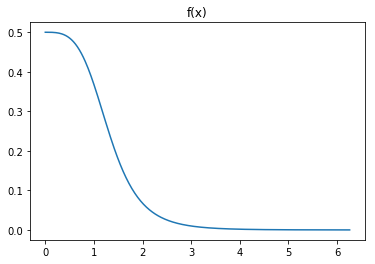

In [13]:
xs = [float(i/50) for i in range(int(50*Pi_constant*2))]
ys = [f_of_x(x) for x in xs]

plt.plot(xs, ys)
plt.title('f(x)')

We can observe that the funtion is active in the appriximate interval of $(0, 3)$ and
innactive past a neighborhood of 3. We propose the following function:

$$g(x) = Ae^{-\lambda x}$$

So we need to find optimal parameters $A$ and $\lambda$

We can do so using the *normalization condition*:

$$1 = \int^{\infty}_{0} g(x) dx \Rightarrow A = \lambda$$

So if we find the ideal $\lambda$, we´ll find the ideal $g(x)$
 
In order to find this value, we will have to calculate the variance for different 
values of $\lambda$ in the interval $[0.05, 3]$ and use the $\lambda$ with the
lowest variance

The algorithm would be as follows:

1. Start at $\lambda = 0.05$

2. Calculate variance

3. Increase $\lambda$

4. Repeat steps 2 and 3 until reaching the last $\lambda$

5. Pick optimal $\lambda$ (the one with the lowest variance)

6. Use Importance Sampling with Monte Carlo to calculate the integral

Code for finding the optimal $\lambda$:

In [14]:
### START FUNCTION ###
def g_of_x(x, A, lamda):
    e = 2.71828
    return A*math.pow(e, -1*lamda*x)
### END FUNCTION ###

### START FUNCTION ###
def inverse_G_of_r(r, lamda):
    return (-1 * math.log(float(r)))/lamda
### END FUNCTION ###

### START FUNCTION ###
def get_IS_variance(lamda, num_samples):
    """
    This function calculates the variance if a Monte Carlo
    using importance sampling.
    Args:
    - lamda (float) : lamdba value of g(x) being tested
    Return: 
    - Variance
    """
    A = lamda
    int_max = 5
    
    # get sum of squares
    running_total = 0
    for i in range(num_samples):
        x = get_rand_number(0, int_max)
        running_total += (f_of_x(x)/g_of_x(x, A, lamda))**2
    
    sum_of_sqs = running_total / num_samples
    
    # get squared average
    running_total = 0
    for i in range(num_samples):
        x = get_rand_number(0, int_max)
        running_total += f_of_x(x)/g_of_x(x, A, lamda)
    sq_ave = (running_total/num_samples)**2
    
    
    return sum_of_sqs - sq_ave
### END FUNCTION ###

# get variance as a function of lambda by testing many
# different lambdas

test_lamdas = [i*0.05 for i in range(1, 61)]
variances = []

for i, lamda in enumerate(test_lamdas):
    print(f"lambda {i+1}/{len(test_lamdas)}: {lamda}")
    A = lamda
    variances.append(get_IS_variance(lamda, 10000))
    clear_output(wait=True)
    
optimal_lamda = test_lamdas[np.argmin(np.asarray(variances))]
IS_variance = variances[np.argmin(np.asarray(variances))]

print(f"Optimal Lambda: {optimal_lamda}")
print(f"Optimal Variance: {IS_variance}")
print(f"Error: {(IS_variance/10000)**0.5}") 

Optimal Lambda: 1.6500000000000001
Optimal Variance: 0.047144023396919144
Error: 0.0021712674500604283


We can observe that the error decreased in a factor of approximately 2 using the
same number of samples, but with Importance Sampling.

## Simulation

Now we perform Monte Carlo Simulation with the optimized $g(x)$ function:

In [15]:
### START FUNCTION ###
def importance_sampling_Monte_Carlo(lamda, num_samples):
    A = lamda
    running_total = 0
    for i in range(num_samples):
        r = get_rand_number(0,1)
        running_total += f_of_x(inverse_G_of_r(r, lamda=lamda))/g_of_x(inverse_G_of_r(r, lamda=lamda), A, lamda)
    approximation = float(running_total/num_samples)
    return approximation
### END FUNCTION ###

We run the simulation:

In [16]:
num_samples = 10000
approx = importance_sampling_Monte_Carlo(optimal_lamda, num_samples)
variance = get_IS_variance(optimal_lamda, num_samples)
error = (variance/num_samples)**0.5

# display results
print(f"Importance Sampling Approximation: {approx}")
print(f"Variance: {variance}")
print(f"Error: {error}")



Importance Sampling Approximation: 0.701366357870612
Variance: 0.05249046464462348
Error: 0.0022910797595156627
